In [1]:
from utils import *
from scipy.stats import qmc
from scipy.stats import spearmanr
from scipy import optimize
import os
import pandas as pd

In [2]:
def g(ell, gp, mean_ntk, data):
    try:
        gp.set_params(**{'kernel__k2__length_scale': ell})
    except:
        gp.set_params(**{'kernel__k1__k2__length_scale': ell})


    gp.fit(data[0], data[1])
    mean = gp.predict(data[2])
    
    return np.sqrt(np.mean((mean_ntk - mean)**2))

In [3]:
arrsize=30
tmp = np.linspace(-3,3, arrsize)
X, Y = np.meshgrid(tmp, tmp)
Z = -20*np.exp(-0.2 * np.sqrt(0.5*(X**2 + Y**2))) - np.exp(0.5 *(np.cos(2*np.pi*X) + np.cos(2*np.pi*Y))) + np.e + 20

bigX = np.stack((X,Y), axis=2).reshape(-1,2)
smolY = Z.reshape(-1,1)


datasets = processing(bigX, smolY, noise = 0.15)
X_orig, y = datasets['orig']
X_norm, _ = datasets['norm']
X_train, y_train, y_train_noisy = datasets['orig train']
X_norm_train, _, _ = datasets['norm train']



Text(0.02, 0.5, 'Gaus $\\longleftarrow$ LPK $\\longrightarrow$ NTK')

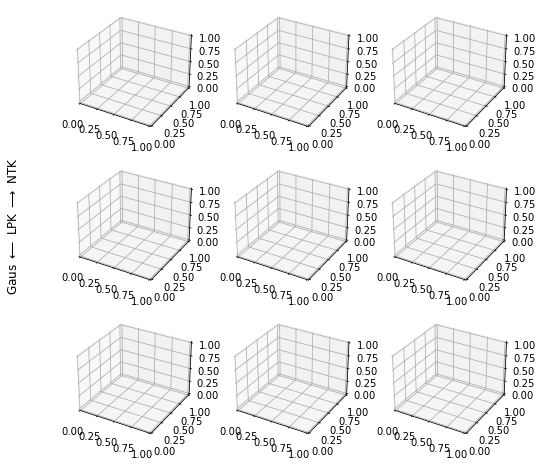

In [4]:
fig, axes = plt.subplots(3, 3, figsize=(6,6))
axes = axes.ravel()
for i in range(0,9):
    axes[i].remove()
    axes[i] = plt.subplot(3,3,i + 1, projection='3d')
    axes[i].patch.set_alpha(0)

fig.supylabel(r'Gaus $\longleftarrow$ LPK $\longrightarrow$ NTK')

/home/rona1das/Documents/code/python/thesis/kernel.py:63: RuntimeWarning: divide by zero encountered in true_divide
  K_prime = 2 * self.bias**2 * products[-1] * (1 + sum(1/np.array(products)))
/home/rona1das/Documents/code/python/thesis/kernel.py:63: RuntimeWarning: invalid value encountered in multiply
  K_prime = 2 * self.bias**2 * products[-1] * (1 + sum(1/np.array(products)))
/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__bias is close to the specified lower bound 1e-09. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


41.4**2 * NTK(depth=3, c=2.000, bias=0.000)
41.4**2 * Matern(length_scale=0.0879, nu=0.5)
0.978**2 * Matern(length_scale=0.118, nu=inf)


/home/rona1das/Documents/code/python/thesis/kernel.py:63: RuntimeWarning: divide by zero encountered in true_divide
  K_prime = 2 * self.bias**2 * products[-1] * (1 + sum(1/np.array(products)))
/home/rona1das/Documents/code/python/thesis/kernel.py:63: RuntimeWarning: invalid value encountered in multiply
  K_prime = 2 * self.bias**2 * products[-1] * (1 + sum(1/np.array(products)))
/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__bias is close to the specified lower bound 1e-09. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


13.8**2 * NTK(depth=25, c=2.000, bias=0.000)
13.8**2 * Matern(length_scale=0.0815, nu=0.5)
0.985**2 * Matern(length_scale=0.112, nu=inf)


/home/rona1das/Documents/code/python/thesis/kernel.py:63: RuntimeWarning: divide by zero encountered in true_divide
  K_prime = 2 * self.bias**2 * products[-1] * (1 + sum(1/np.array(products)))
/home/rona1das/Documents/code/python/thesis/kernel.py:63: RuntimeWarning: invalid value encountered in multiply
  K_prime = 2 * self.bias**2 * products[-1] * (1 + sum(1/np.array(products)))
/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__bias is close to the specified lower bound 1e-09. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


13.8**2 * NTK(depth=100, c=2.000, bias=0.000)
13.8**2 * Matern(length_scale=0.163, nu=0.5)
0.881**2 * Matern(length_scale=0.169, nu=inf)


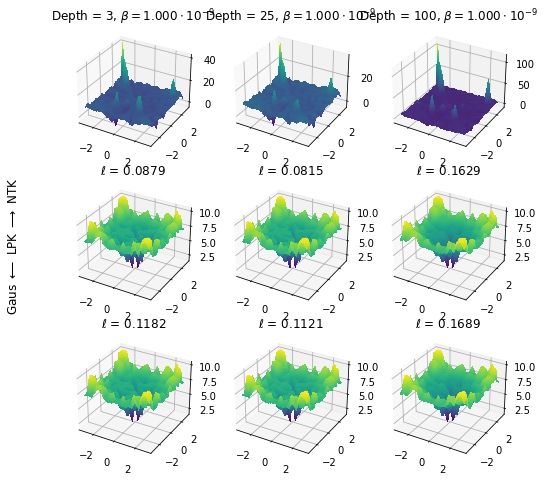

In [5]:
fig, axes = plt.subplots(3, 3, figsize=(8,8))
axes = axes.ravel()
for i in range(0,9):
    axes[i].remove()
    axes[i] = plt.subplot(3,3,i + 1, projection='3d')
    axes[i].patch.set_alpha(0)

fig.supylabel(r'Gaus $\longleftarrow$ LPK $\longrightarrow$ NTK')

data = (X_train, y_train, X_orig)

for j in range(0,3):
    if j == 0 : depth=3
    if j == 1 : depth=25
    if j == 2 : depth=100

    ntk = (
        ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e5)) * 
        NTK(depth=depth, c=2, bias=0.1, 
            bias_bounds=(1e-9, 1e5)) 
        # +
        # WhiteKernel(
        #     noise_level=0.15**2, 
        #     noise_level_bounds=(1e-4, 0.5))#(0.001, 1))
    )

    gp_ntk = GPR(kernel=ntk, normalize_y=True, alpha=1e-5, n_restarts_optimizer=9, random_state=3480795)
    gp_ntk.fit(data[0], data[1])
    mean_ntk = gp_ntk.predict(data[2])

    print(gp_ntk.kernel_)



    lpk = (
        ConstantKernel(
            constant_value=gp_ntk.kernel_.get_params()['k1__constant_value'],
            constant_value_bounds='fixed'
        ) *
        Matern(
            nu=1/2,
            # anisotropic true -> trying to fit product of laplace kernels with different lengthscales
            length_scale=1,
            length_scale_bounds='fixed'
        ) 
        # + 
        # WhiteKernel(
        #     noise_level=gp_ntk.kernel_.get_params()['k2__noise_level'],
        #     noise_level_bounds='fixed'
        # )
    )

    gp_lpk = GPR(kernel=lpk, alpha=1e-5, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)

    ell_lpk = optimize.minimize_scalar(g, args=(
        gp_lpk, mean_ntk, data), 
        method='bounded', bounds=[0.0001, 10], options={'maxiter': 10000})
    # for i in range(0, 10):
    #     tmp = optimize.minimize_scalar(g, args=(
    #         gp_lpk, mean_ntk, data),
    #         method='bounded', bounds=[0.0001, 10*(10**i)], options={'maxiter': 10000})
    #     if tmp.fun < ell_lpk.fun:
    #         ell_lpk = tmp

    try:
        gp_lpk.set_params(**{'kernel__k2__length_scale': ell_lpk.x})
    except:
        gp_lpk.set_params(**{'kernel__k1__k2__length_scale': ell_lpk.x})
    gp_lpk.fit(data[0], data[1])
    mean_lpk_opt = gp_lpk.predict(data[2])

    print(gp_lpk.kernel_)



    rbf = (
        ConstantKernel(
            constant_value=1,
            constant_value_bounds=(1e-9, 1e5)
        ) *
            Matern(
                nu=np.inf,
                length_scale=1,
                length_scale_bounds='fixed'
            )
        )

    gp_rbf = GPR(kernel=rbf, alpha=1e-5, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)


    ell_rbf = optimize.minimize_scalar(g, args=(
        gp_rbf, mean_ntk, data), 
        method='bounded', bounds=[0.0001, 10], options={'maxiter': 10000})
    # for i in range(0, 10):
    #     tmp = optimize.minimize_scalar(g, args=(
    #         gp_rbf, mean_ntk, data),
    #         method='bounded', bounds=[0.0001, 10*(10**i)], options={'maxiter': 10000})
    #     if tmp.fun < ell_rbf.fun:
    #         ell_rbf = tmp

    try:
        gp_rbf.set_params(**{'kernel__k2__length_scale': ell_rbf.x})
    except:
        gp_rbf.set_params(**{'kernel__k1__k2__length_scale': ell_rbf.x})
    gp_rbf.fit(data[0], data[1])
    mean_rbf_opt = gp_rbf.predict(data[2])
    print(gp_rbf.kernel_)



    axes[j + 0].contourf(
        X_orig[:,0].reshape(-1, arrsize), 
        X_orig[:,1].reshape(-1, arrsize), 
        mean_ntk.reshape(-1, arrsize),
        levels=100)
    beta = gp_ntk.kernel_.get_params()['k2__bias']
    a,b = f'{beta:.3e}'.split('e')
    b = int(b)
    axes[j + 0].set_title(f'Depth = {depth}, ' + rf'$\beta = {a}\cdot 10^{{{b}}}$')

    axes[j + 3].contourf(
        X_orig[:,0].reshape(-1, arrsize), 
        X_orig[:,1].reshape(-1, arrsize), 
        mean_lpk_opt.reshape(-1, arrsize),
        levels=100)
    axes[j + 3].set_title(r'$\ell$ =' + f" {round(gp_lpk.kernel_.get_params()['k2__length_scale'], 4)}")

    axes[j + 6].contourf(
        X_orig[:,0].reshape(-1, arrsize), 
        X_orig[:,1].reshape(-1, arrsize), 
        mean_rbf_opt.reshape(-1, arrsize),
        levels=100)
    axes[j + 6].set_title(r'$\ell$ =' + f" {round(gp_rbf.kernel_.get_params()['k2__length_scale'], 4)}")
    

In [6]:
fig.tight_layout()
fig.savefig('./ackleyNoNormNoNoise.svg')

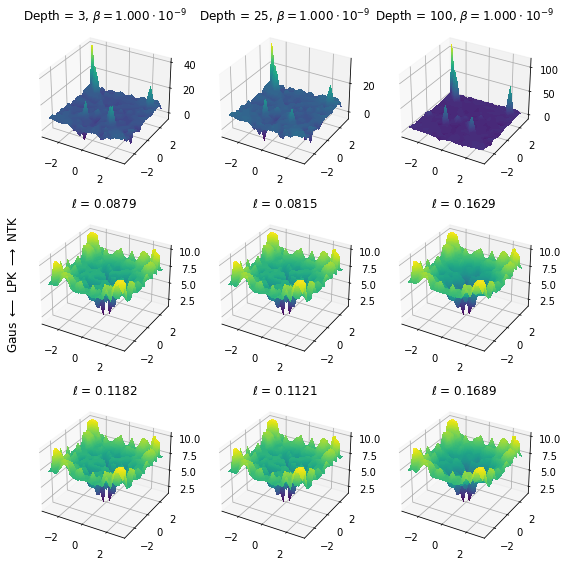

In [7]:
fig

In [26]:
axes[0 + 0].contourf(
        X_orig[:,0].reshape(-1, 40), 
        X_orig[:,1].reshape(-1, 40), 
        mean_ntk.reshape(-1, 40),
        levels=100, cmap='plasma')
beta = gp_ntk.kernel_.get_params()['k2__bias']
a,b = f'{beta:.3e}'.split('e')
b = int(b)
axes[0 + 0].set_title(f'Depth = {depth}, ' + rf'$\beta = {a}\cdot 10^{{{b}}}$')

axes[0 + 3].contourf(
    X_orig[:,0].reshape(-1, 40), 
    X_orig[:,1].reshape(-1, 40), 
    mean_lpk_opt.reshape(-1, 40),
    levels=100, cmap='viridis')
axes[0 + 3].set_title(r'$\ell$ =' + f" {round(gp_lpk.kernel_.get_params()['k2__length_scale'], 4)}")

Text(0.5, 0.92, '$\\ell$ = 23606797.7501')

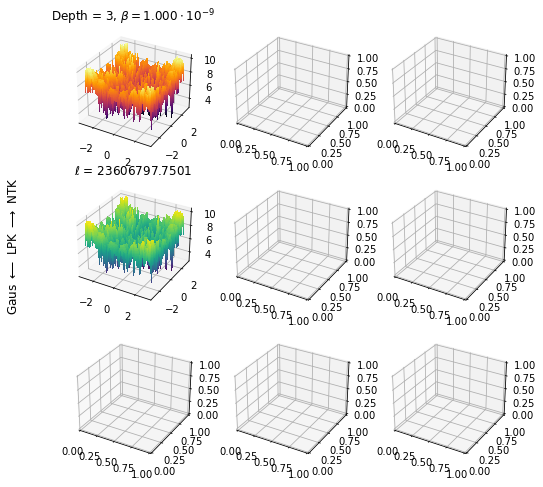

In [27]:
fig